In [4]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm
# Path to your LG font images directory
image_dir = '/Selected_LG'

# Load the dataset from Hugging Face
dataset = load_dataset('ta4tsering/Lhasa_kanjur_transcription_datasets', split='test')

# Load the pre-trained RoBERTa model and tokenizer
model_name = 'openpecha/tibetan_RoBERTa_S_e6'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Prepare the dataset: Map filenames to transcriptions
filename_to_transcription = {row['filename']: row['label'] for row in dataset}

# Function to convert text to vector using the RoBERTa model
def text_to_vector(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1)  # Use mean pooling

# Collect vectors and corresponding images
data = []
for filename in tqdm(os.listdir(image_dir)):
    transcription = filename_to_transcription.get(filename)
    if transcription:
        vector = text_to_vector(transcription)
        image_path = os.path.join(image_dir, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(image, [64, 2048])
        image = image / 255.0  # Normalize to [0, 1]
        data.append((image, vector))

# Convert list to TensorFlow dataset
images, vectors = zip(*data)
images = tf.convert_to_tensor(images)
vectors = tf.convert_to_tensor(vectors)

# Ensure vectors have the correct shape (None, 768)
if len(vectors.shape) == 3:
    vectors = tf.squeeze(vectors, axis=1)

# Create a TensorFlow dataset with inputs (images, vectors) and targets (images)
dataset = tf.data.Dataset.from_tensor_slices(((images, vectors), images)).batch(16)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1000/1000 [

In [5]:
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Custom Keras layer to expand and tile dimensions
class ExpandAndTileLayer(layers.Layer):
    def __init__(self, tile_shape):
        super(ExpandAndTileLayer, self).__init__()
        self.tile_shape = tile_shape

    def call(self, inputs):
        expanded = tf.expand_dims(tf.expand_dims(inputs, 1), 1)
        return tf.tile(expanded, [1, self.tile_shape[0], self.tile_shape[1], 1])

# Define the conditional UNet architecture
def create_conditional_unet(input_shape, condition_dim):
    inputs = layers.Input(shape=input_shape)
    condition = layers.Input(shape=(condition_dim,))
    
    # Combine inputs and conditions
    condition_tiled = ExpandAndTileLayer(input_shape[:2])(condition)
    x = layers.Concatenate()([inputs, condition_tiled])

    # Add convolutional layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Add upsampling layers
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model([inputs, condition], outputs)

class DDPMTrainingStep(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        super(DDPMTrainingStep, self).__init__(**kwargs)
        self.model = model
        self.mse_loss = MeanSquaredError()

    def call(self, inputs):
        images, conditions = inputs
        noisy_images = images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.1)
        predicted_images = self.model([noisy_images, conditions], training=True)
        loss = self.mse_loss(images, predicted_images)
        self.add_loss(loss)
        return predicted_images

    def compute_output_shape(self, input_shape):
        return input_shape[0]  # Output shape should match the image input shape

input_shape = (64, 2048, 1)  # Adjust based on your image dimensions
condition_dim = 768  # Dimensionality of the transcription vectors

# Create the UNet model
unet_model = create_conditional_unet(input_shape, condition_dim)

# Wrap the UNet model with the custom training step
inputs = tf.keras.Input(shape=input_shape)
conditions = tf.keras.Input(shape=(condition_dim,))
outputs = DDPMTrainingStep(unet_model)([inputs, conditions])
training_model = tf.keras.Model(inputs=[inputs, conditions], outputs=outputs)
training_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Show model summary
training_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 2048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ddpm_training_step… │ (None, 64, 2048,  │    738,817 │ input_layer_6[0]… │
│ (DDPMTrainingStep)  │ 1)                │            │ input_layer_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 738,817 (2.82 MB)

 Trainable params: 738,817 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
training_model.fit(dataset, epochs=100)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.0277
Epoch 2/100
14/63 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0262

Raw Transcription: མེ་ཏོག་དང༌། པོག་ཕོར་བཞག་ནས་དགེ་སློང་མ་སྐད་སྙན་པ་དག་བསྐོས་ཏེ་བསྡད་པ་དང༌། ཆུང་མ་དེ་དག་ཀྱང་ཁྱིམ་ཐབ་དག་བསྐྱལ་ཏེ་ཆོས་སྦྱིན་གྱི་དྲུང་དུ་ལྷགས་ནས་ཆོས་སྦྱིན་གྱིས་དེ་དག་ལ་


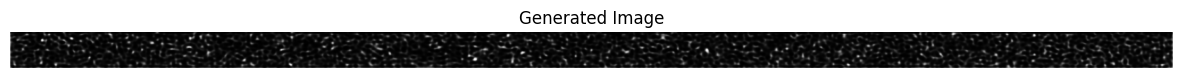

In [14]:
import matplotlib.pyplot as plt

def display_generated_image(model, transcription_text, noise_shape):
    # Convert the transcription text to a vector
    transcription_vector = text_to_vector(transcription_text)
    
    # Ensure the transcription vector has the correct shape
    transcription_vector = tf.squeeze(transcription_vector, axis=0)  # Remove extra dimensions if any
    transcription_vector = tf.expand_dims(transcription_vector, axis=0)  # Add batch dimension

    # Create random noise
    noise = tf.random.normal(shape=noise_shape)

    # Predict the image from noise given the transcription vector
    generated_image = model([noise, transcription_vector], training=False)

    # Convert the generated image to numpy
    generated_image = generated_image[0, :, :, 0].numpy()

    # Display the generated image
    plt.figure(figsize=(15, 5))
    
    # Display generated image
    plt.title("Generated Image")
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    
    plt.show()

# Take a sample transcription from the training data
sample_index = 0
sample_transcription = filename_to_transcription[list(filename_to_transcription.keys())[sample_index]]
noise_shape = (1, 64, 2048, 1)  # Shape of the noise input

# Print the raw transcription
print(f"Raw Transcription: {sample_transcription}")

# Display the generated image
display_generated_image(unet_model, sample_transcription, noise_shape)
